# Preprocessing Data

In [2]:
import pandas as pd

# Load the dataset
file_path = "holiday_movies.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Display basic information
df.info()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           2265 non-null   object 
 1   title_type       2265 non-null   object 
 2   primary_title    2265 non-null   object 
 3   original_title   2265 non-null   object 
 4   year             2265 non-null   int64  
 5   runtime_minutes  2076 non-null   float64
 6   genres           2233 non-null   object 
 7   simple_title     2265 non-null   object 
 8   average_rating   2265 non-null   float64
 9   num_votes        2265 non-null   int64  
 10  christmas        2265 non-null   bool   
 11  hanukkah         2265 non-null   bool   
 12  kwanzaa          2265 non-null   bool   
 13  holiday          2265 non-null   bool   
dtypes: bool(4), float64(2), int64(2), object(6)
memory usage: 185.9+ KB


,tconst,title_type,primary_title,original_title,year,runtime_minutes,genres,simple_title,average_rating,num_votes,christmas,hanukkah,kwanzaa,holiday
0,tt0020356,movie,Sailor's Holiday,Sailor's Holiday,1929,58.0,Comedy,sailors holiday,5.4,55,False,False,False,True
1,tt0020823,movie,The Devil's Holiday,The Devil's Holiday,1930,80.0,"Drama,Romance",the devils holiday,6.0,242,False,False,False,True
2,tt0020985,movie,Holiday,Holiday,1930,91.0,"Comedy,Drama",holiday,6.3,638,False,False,False,True
3,tt0021268,movie,Holiday of St. Jorgen,Prazdnik svyatogo Yorgena,1930,83.0,Comedy,holiday of st jorgen,7.4,256,False,False,False,True
4,tt0021377,movie,Sin Takes a Holiday,Sin Takes a Holiday,1930,81.0,"Comedy,Romance",sin takes a holiday,6.1,740,False,False,False,True


In [3]:
# Explode genres column for better analysis
df_exploded = df.assign(genres=df['genres'].str.split(',')).explode('genres')

# Define function to group years into periods
def group_years(year, period=5):
    return f"{(year // period) * period}-{((year // period) * period) + (period - 1)}"

df_exploded['year_period'] = df_exploded['year'].apply(lambda x: group_years(x, period=5))

# Interactive Dashboard

In [7]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px


# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Holiday Movies Analysis"),

    # Dropdown for selecting period
    dcc.Dropdown(
        id='period-dropdown',
        options=[{'label': str(p), 'value': p} for p in sorted(df_exploded['year_period'].unique())],
        multi=True,
        placeholder="Select periods"
    ),

    # Dropdown for selecting genre
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': g, 'value': g} for g in sorted(df_exploded['genres'].dropna().unique())],
        multi=True,
        placeholder="Select genres"
    ),

    # Scatterplot
    dcc.Graph(id='scatter-plot'),

    # Heatmap
    dcc.Graph(id='heatmap'),

    # Line chart for ratings over time by genre
    dcc.Graph(id='rating-trend'),


    # Line chart for number of votes over time by genre
    dcc.Graph(id='num-votes-trend'),

    # 100% Stacked Area Chart for Number of Movies Over Time by Genre
    dcc.Graph(id='stacked-area-chart'),

])

# Callbacks
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_scatter(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]
    fig = px.scatter(filtered_df, x='runtime_minutes', y='average_rating', color='genres',
                     title="Runtime vs. Rating by Genre", labels={'runtime_minutes': "Runtime (min)", 'average_rating': "Rating"})
    return fig

@app.callback(
    Output('heatmap', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_heatmap(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]
    genre_trends = filtered_df.groupby(['year_period', 'genres']).agg({'tconst': 'count'}).reset_index()
    heatmap_data = genre_trends.pivot(index='genres', columns='year_period', values='tconst').fillna(0)
    fig = px.imshow(heatmap_data, labels={'x': "Year Period", 'y': "Genre", 'color': "Movie Count"},
                    title="Holiday Movie Production Trends Over Time", color_continuous_scale='Viridis')
    return fig
@app.callback(
    Output('rating-trend', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_rating_trend(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]

    rating_trends = filtered_df.groupby(['year_period', 'genres']).agg({'average_rating': 'mean'}).reset_index()

    # Ensure 'year_period' is treated as an ordered categorical variable
    rating_trends['year_period'] = pd.Categorical(rating_trends['year_period'],
                                                  categories=sorted(rating_trends['year_period'].unique()),
                                                  ordered=True)

    fig = px.line(rating_trends, x='year_period', y='average_rating', color='genres',
                  title="Average Rating Over Time by Genre", labels={'average_rating': "Average Rating"})

    return fig

@app.callback(
    Output('stacked-area-chart', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_stacked_area(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]

    genre_trends = filtered_df.groupby(['year_period', 'genres']).agg({'tconst': 'count'}).reset_index()
    genre_totals = genre_trends.groupby('year_period')['tconst'].transform('sum')
    genre_trends['percentage'] = genre_trends['tconst'] / genre_totals * 100

    fig = px.area(genre_trends, x='year_period', y='percentage', color='genres',
                  title="Percentage of Movies by Genre Over Time (100% Stacked Area Chart)",
                  labels={'percentage': "Percentage of Total Movies"},
                  line_group='genres', groupnorm='percent')
    return fig

@app.callback(
    Output('num-votes-trend', 'figure'),
    [Input('period-dropdown', 'value'), Input('genre-dropdown', 'value')]
)
def update_num_votes_trend(selected_periods, selected_genres):
    filtered_df = df_exploded
    if selected_periods:
        filtered_df = filtered_df[filtered_df['year_period'].isin(selected_periods)]
    if selected_genres:
        filtered_df = filtered_df[filtered_df['genres'].isin(selected_genres)]
    votes_trends = filtered_df.groupby(['year_period', 'genres']).agg({'num_votes': 'sum'}).reset_index()
    fig = px.line(votes_trends, x='year_period', y='num_votes', color='genres',
                  title="Total IMDb Votes Over Time by Genre", labels={'num_votes': "Total Votes"})
    return fig
# Run app
if __name__ == '__main__':
    app.run(debug=True, port=8060)


<IPython.core.display.Javascript object>

# Word Cloud

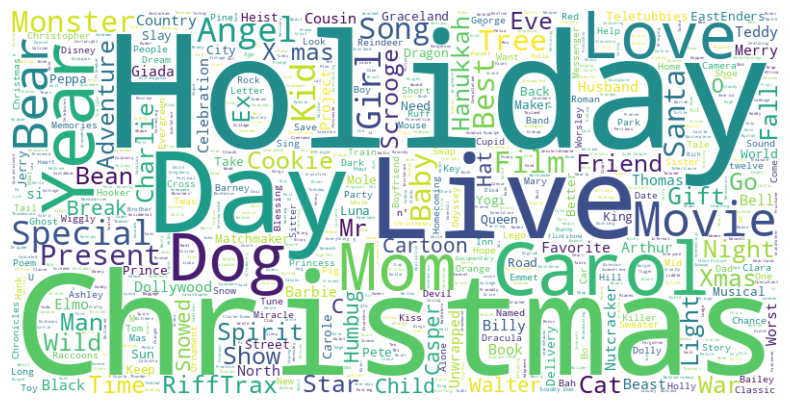

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text from 'primary_title' and 'genres' columns
text_data = " ".join(df_exploded['primary_title'].dropna().astype(str)) + " " + " ".join(df_exploded['genres'].dropna().astype(str))

unique_words = set(text_data.split())

# Generate a word cloud ensuring each word appears only once
wordcloud_unique = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=len(unique_words))
wordcloud_unique.generate(" ".join(unique_words))

# Plot the unique-word word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_unique, interpolation='bilinear')
plt.axis("off")
plt.show()

# Q1: Do higher-rated movies tend to have longer runtimes?

In [1]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import shapiro

In [2]:
# read datasets
holiday_movie_genres = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-12-12/holiday_movie_genres.csv')
holiday_movies = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-12-12/holiday_movies.csv')

Text(0.5, 1.0, 'Top 20 Genres in Holiday Movies')

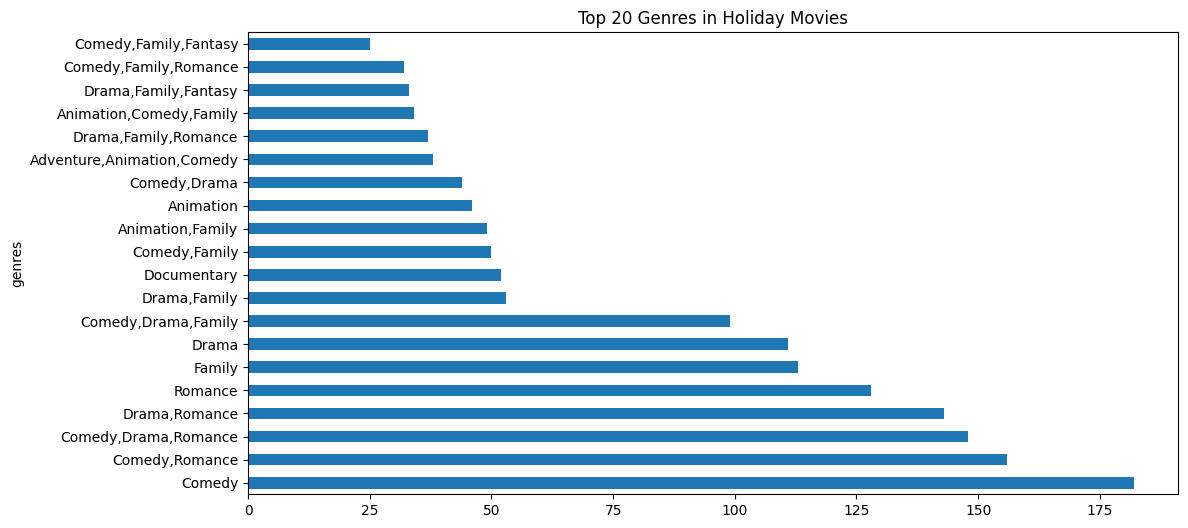

In [3]:
#bar plot for categorical column: genres
plt.figure(figsize=(12, 6))
holiday_movies['genres'].value_counts().head(20).plot(kind='barh')
plt.title('Top 20 Genres in Holiday Movies')

Correlation between average rating and runtime minutes: -0.20


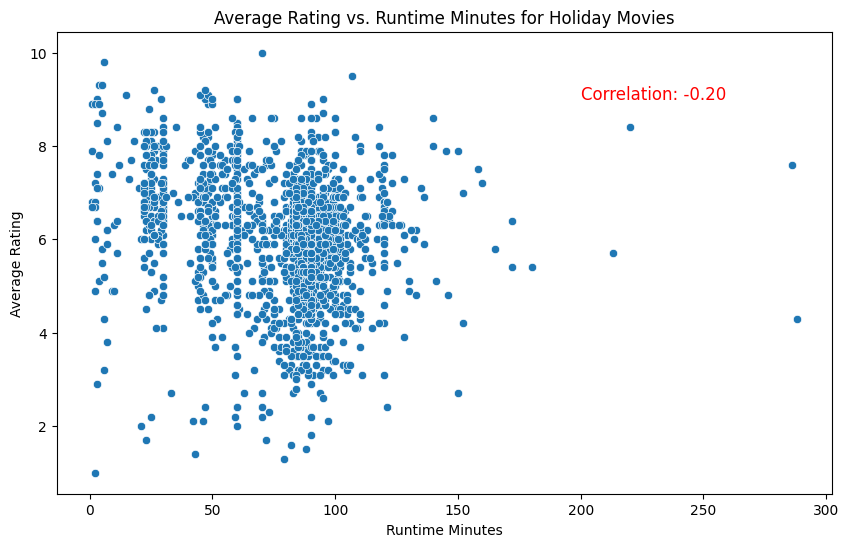

In [4]:
# Create a scatterplot of average_rating vs. runtime_minutes.


# print correlation between average_rating and runtime_minutes and put text in the plot
correlation = holiday_movies['average_rating'].corr(holiday_movies['runtime_minutes'])
print(f'Correlation between average rating and runtime minutes: {correlation:.2f}')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=holiday_movies, x='runtime_minutes', y='average_rating')
plt.title('Average Rating vs. Runtime Minutes for Holiday Movies')
plt.xlabel('Runtime Minutes')
plt.ylabel('Average Rating')
plt.text(200, 9, f'Correlation: {correlation:.2f}', fontsize=12, color='red')
plt.show()

In [5]:
# Make sure to import pandas if not already imported


# Example: holiday_movies is your original DataFrame
# 1) Split the "genres" column on comma -> list of genres
holiday_movies['genres'] = holiday_movies['genres'].str.split(',')

# 2) Explode the lists into rows
holiday_movies_exploded = holiday_movies.explode('genres')

# 3) Strip any leading/trailing whitespace from each genre
holiday_movies_exploded['genres'] = holiday_movies_exploded['genres'].str.strip()




Text(0.5, 1.0, 'Top 20 Genres in Holiday Movies Exploded')

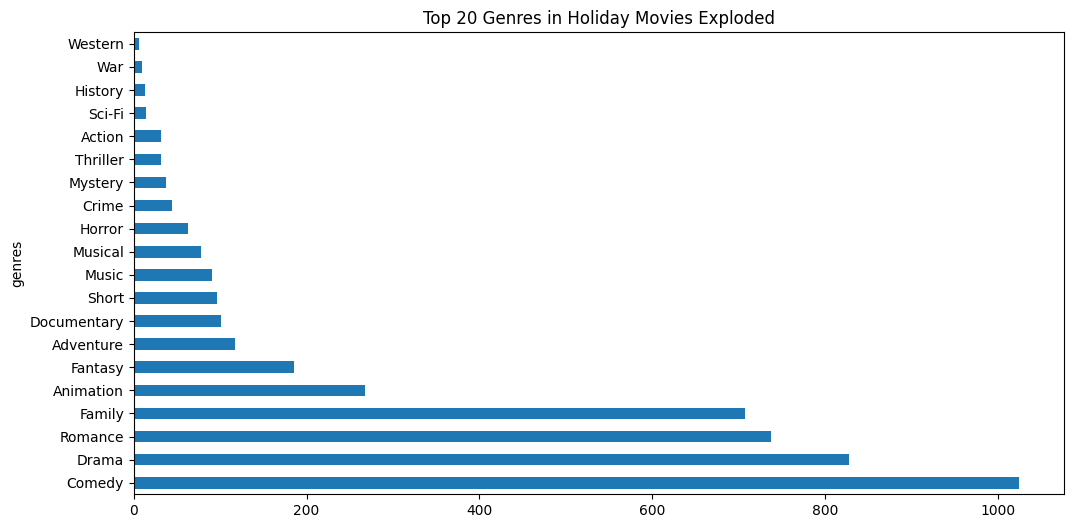

In [6]:
#bar plot for categorical column: genres
plt.figure(figsize=(12, 6))
holiday_movies_exploded['genres'].value_counts().head(20).plot(kind='barh')
plt.title('Top 20 Genres in Holiday Movies Exploded')

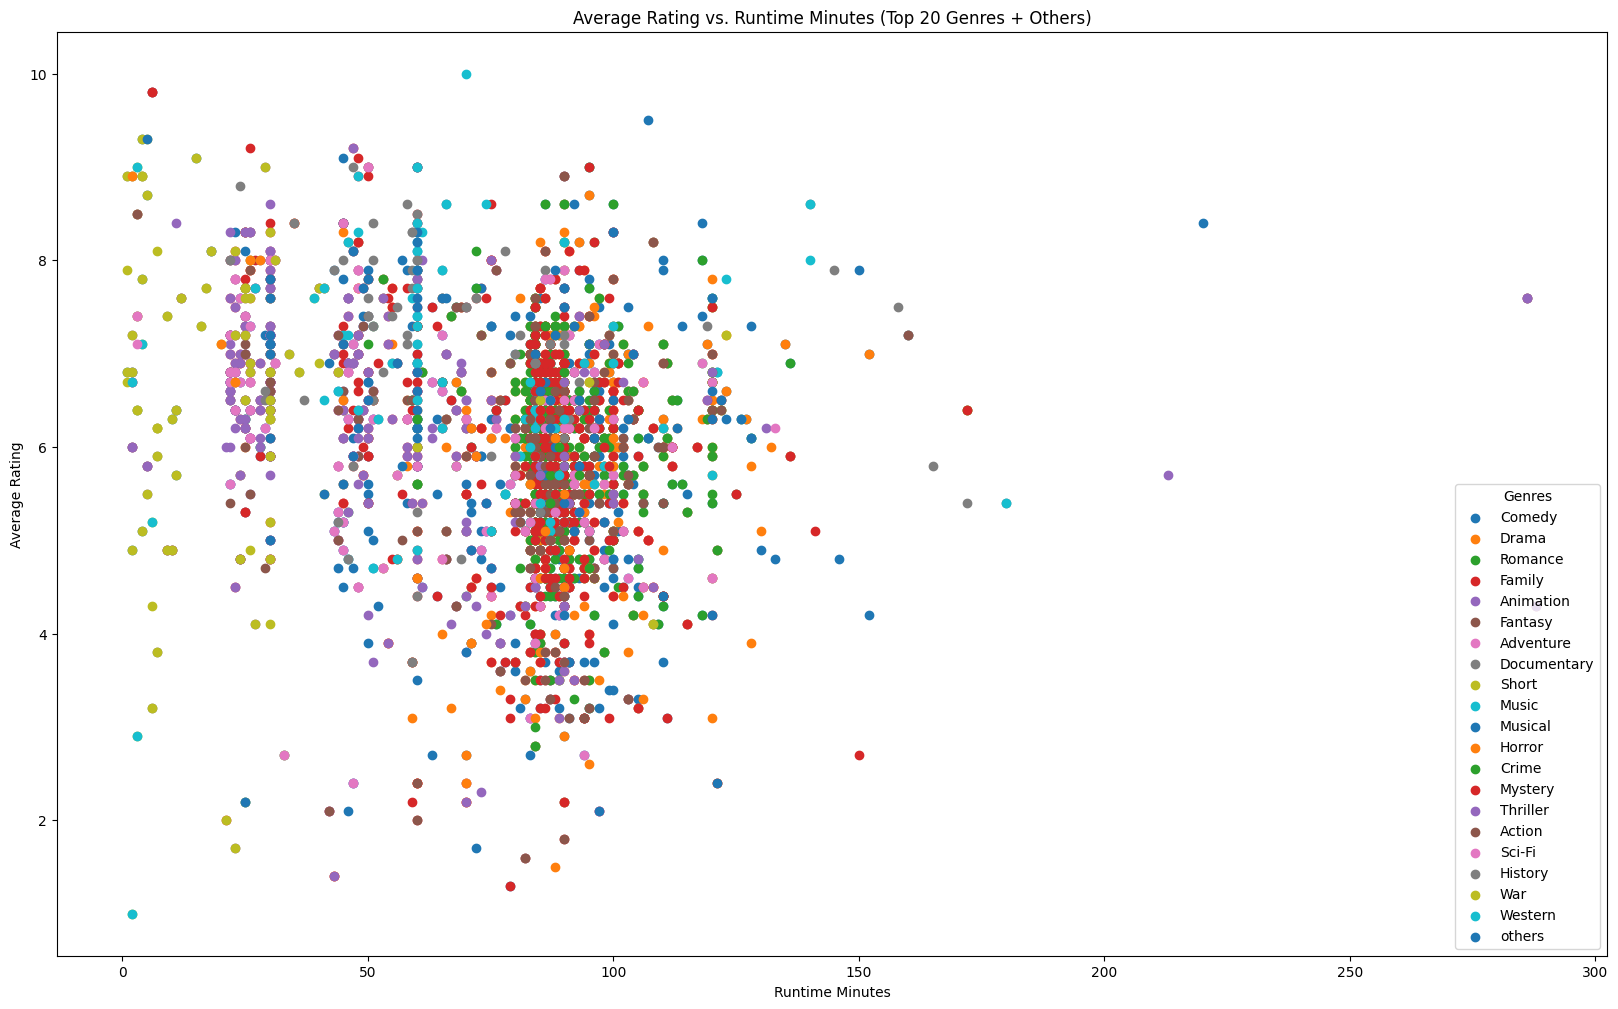

In [7]:

# 1) Count how often each genre appears
genre_counts = holiday_movies_exploded['genres'].value_counts()

# 2) Identify the top 20
top_20_genres = genre_counts.head(20).index

plt.figure(figsize=(20, 12))

# 3) Plot each of the top 20 genres separately
for genre in top_20_genres:
    subset = holiday_movies_exploded[holiday_movies_exploded['genres'] == genre]
    plt.scatter(subset['runtime_minutes'], 
                subset['average_rating'], 
                label=genre)

# 4) Group all remaining genres into "others"
others_subset = holiday_movies_exploded[~holiday_movies_exploded['genres'].isin(top_20_genres)]
plt.scatter(others_subset['runtime_minutes'],
            others_subset['average_rating'],
            label='others')

plt.title('Average Rating vs. Runtime Minutes (Top 20 Genres + Others)')
plt.xlabel('Runtime Minutes')
plt.ylabel('Average Rating')
plt.legend(title='Genres')
plt.show()


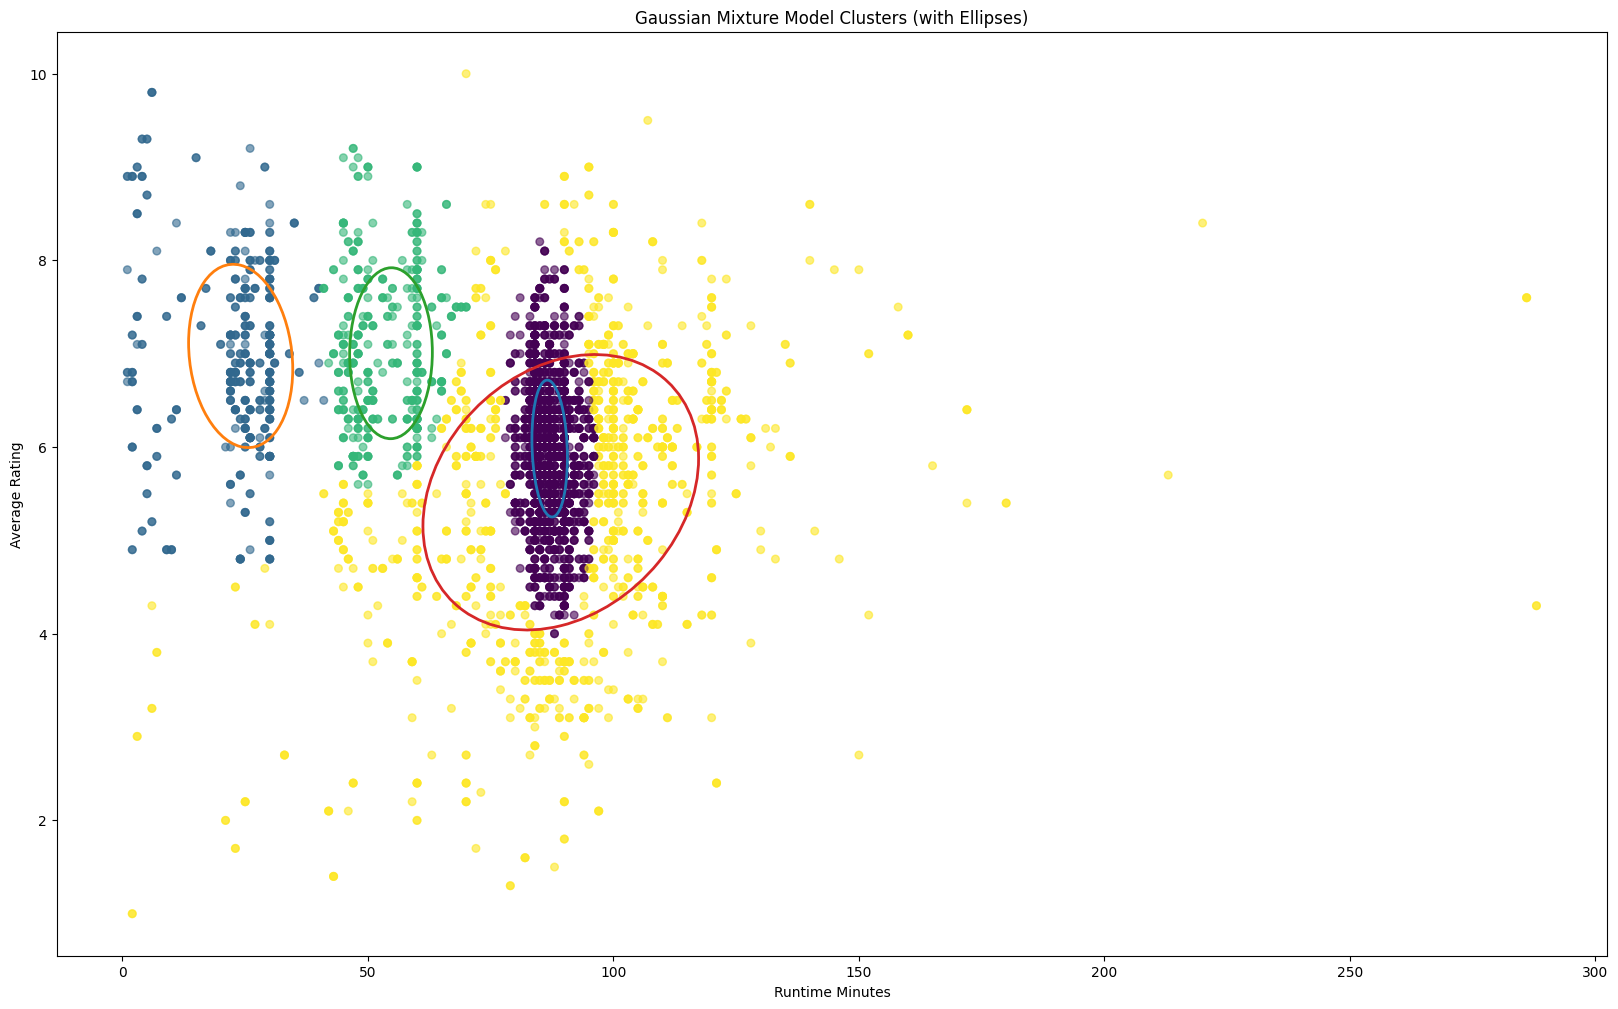

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib.patches as patches

def plot_ellipse(mean, cov, ax, color='black'):
    """
    Plot an ellipse corresponding to 1 standard deviation
    of the Gaussian defined by mean and covariance (2D).
    """
    # Eigen-decompose the covariance to get principal axes
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    
    # Sort eigenvalues in descending order (and reorder eigenvectors accordingly)
    order = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:, order]
    
    # The angle of the ellipse in degrees
    # np.arctan2(y, x) for the direction of the largest eigenvector
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
    
    # The width and height of the ellipse are 2 standard deviations
    # (so that it encloses ~68% of the distribution)
    width, height = 2 * np.sqrt(eigenvals)
    
    # Draw the ellipse
    ell = patches.Ellipse(xy=mean,
                          width=width,
                          height=height,
                          angle=angle,
                          edgecolor=color,
                          facecolor='none',
                          lw=2)
    ax.add_patch(ell)

# Example: We'll cluster holiday_movies' (runtime_minutes, average_rating).
# Drop rows with missing values in these columns to avoid errors.
df_for_clustering = holiday_movies_exploded[['runtime_minutes', 'average_rating']].dropna()

# Convert to NumPy array
X = df_for_clustering.values

# Fit a GMM (using 3 components as an example, but you can choose any number)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)

# Predict cluster labels
labels = gmm.predict(X)

# Create a scatter plot colored by cluster
plt.figure(figsize=(20, 12))
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.6, s=30)
plt.title('Gaussian Mixture Model Clusters (with Ellipses)')
plt.xlabel('Runtime Minutes')
plt.ylabel('Average Rating')

# Plot an ellipse to illustrate each component
ax = plt.gca()  # Get current axes
for i, (mean, cov) in enumerate(zip(gmm.means_, gmm.covariances_)):
    # Use the same color each cluster's points get by default in the scatter
    # Matplotlib typically uses 'C0', 'C1', 'C2', etc., for scatter color cycles.
    color = f'C{i}'
    plot_ellipse(mean, cov, ax, color=color)

plt.show()


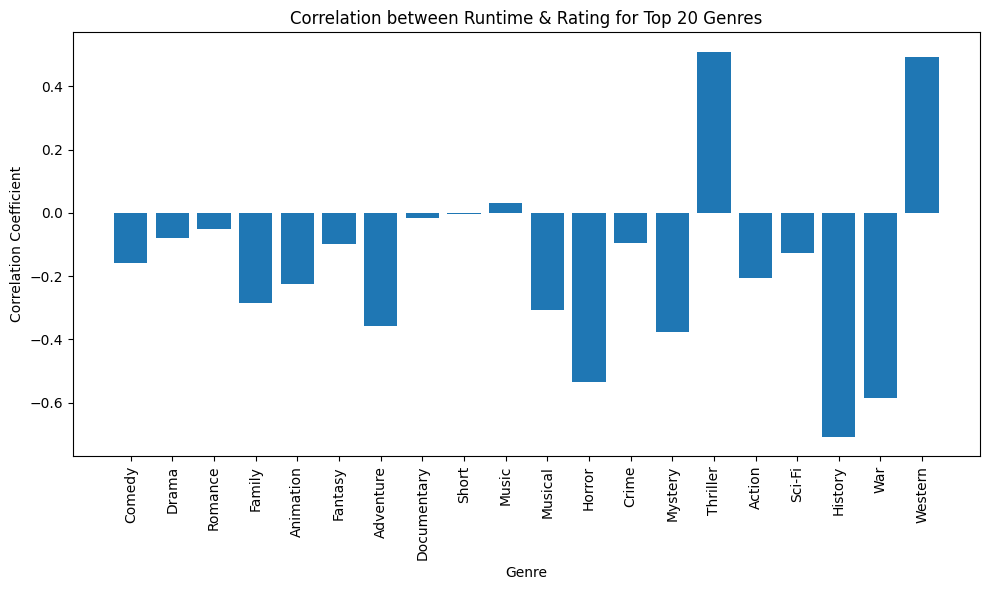

In [9]:


# 1) Identify the top 20 genres
genre_counts = holiday_movies_exploded['genres'].value_counts()
top_20_genres = genre_counts.head(20).index

# 2) For each genre, compute the correlation between runtime_minutes and average_rating
genre_correlations = []
for genre in top_20_genres:
    subset = holiday_movies_exploded[holiday_movies_exploded['genres'] == genre]
    # Drop any rows missing runtime_minutes or average_rating
    subset = subset[['runtime_minutes', 'average_rating']].dropna()

    # If there's fewer than 2 data points, correlation can't be computed
    if len(subset) < 2:
        corr = float('nan')
    else:
        corr = subset['runtime_minutes'].corr(subset['average_rating'])
    genre_correlations.append(corr)

# 3) Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_20_genres, genre_correlations)
plt.xticks(rotation=90)  # rotate genre labels for readability
plt.title("Correlation between Runtime & Rating for Top 20 Genres")
plt.xlabel("Genre")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()  # help avoid label overlap
plt.show()


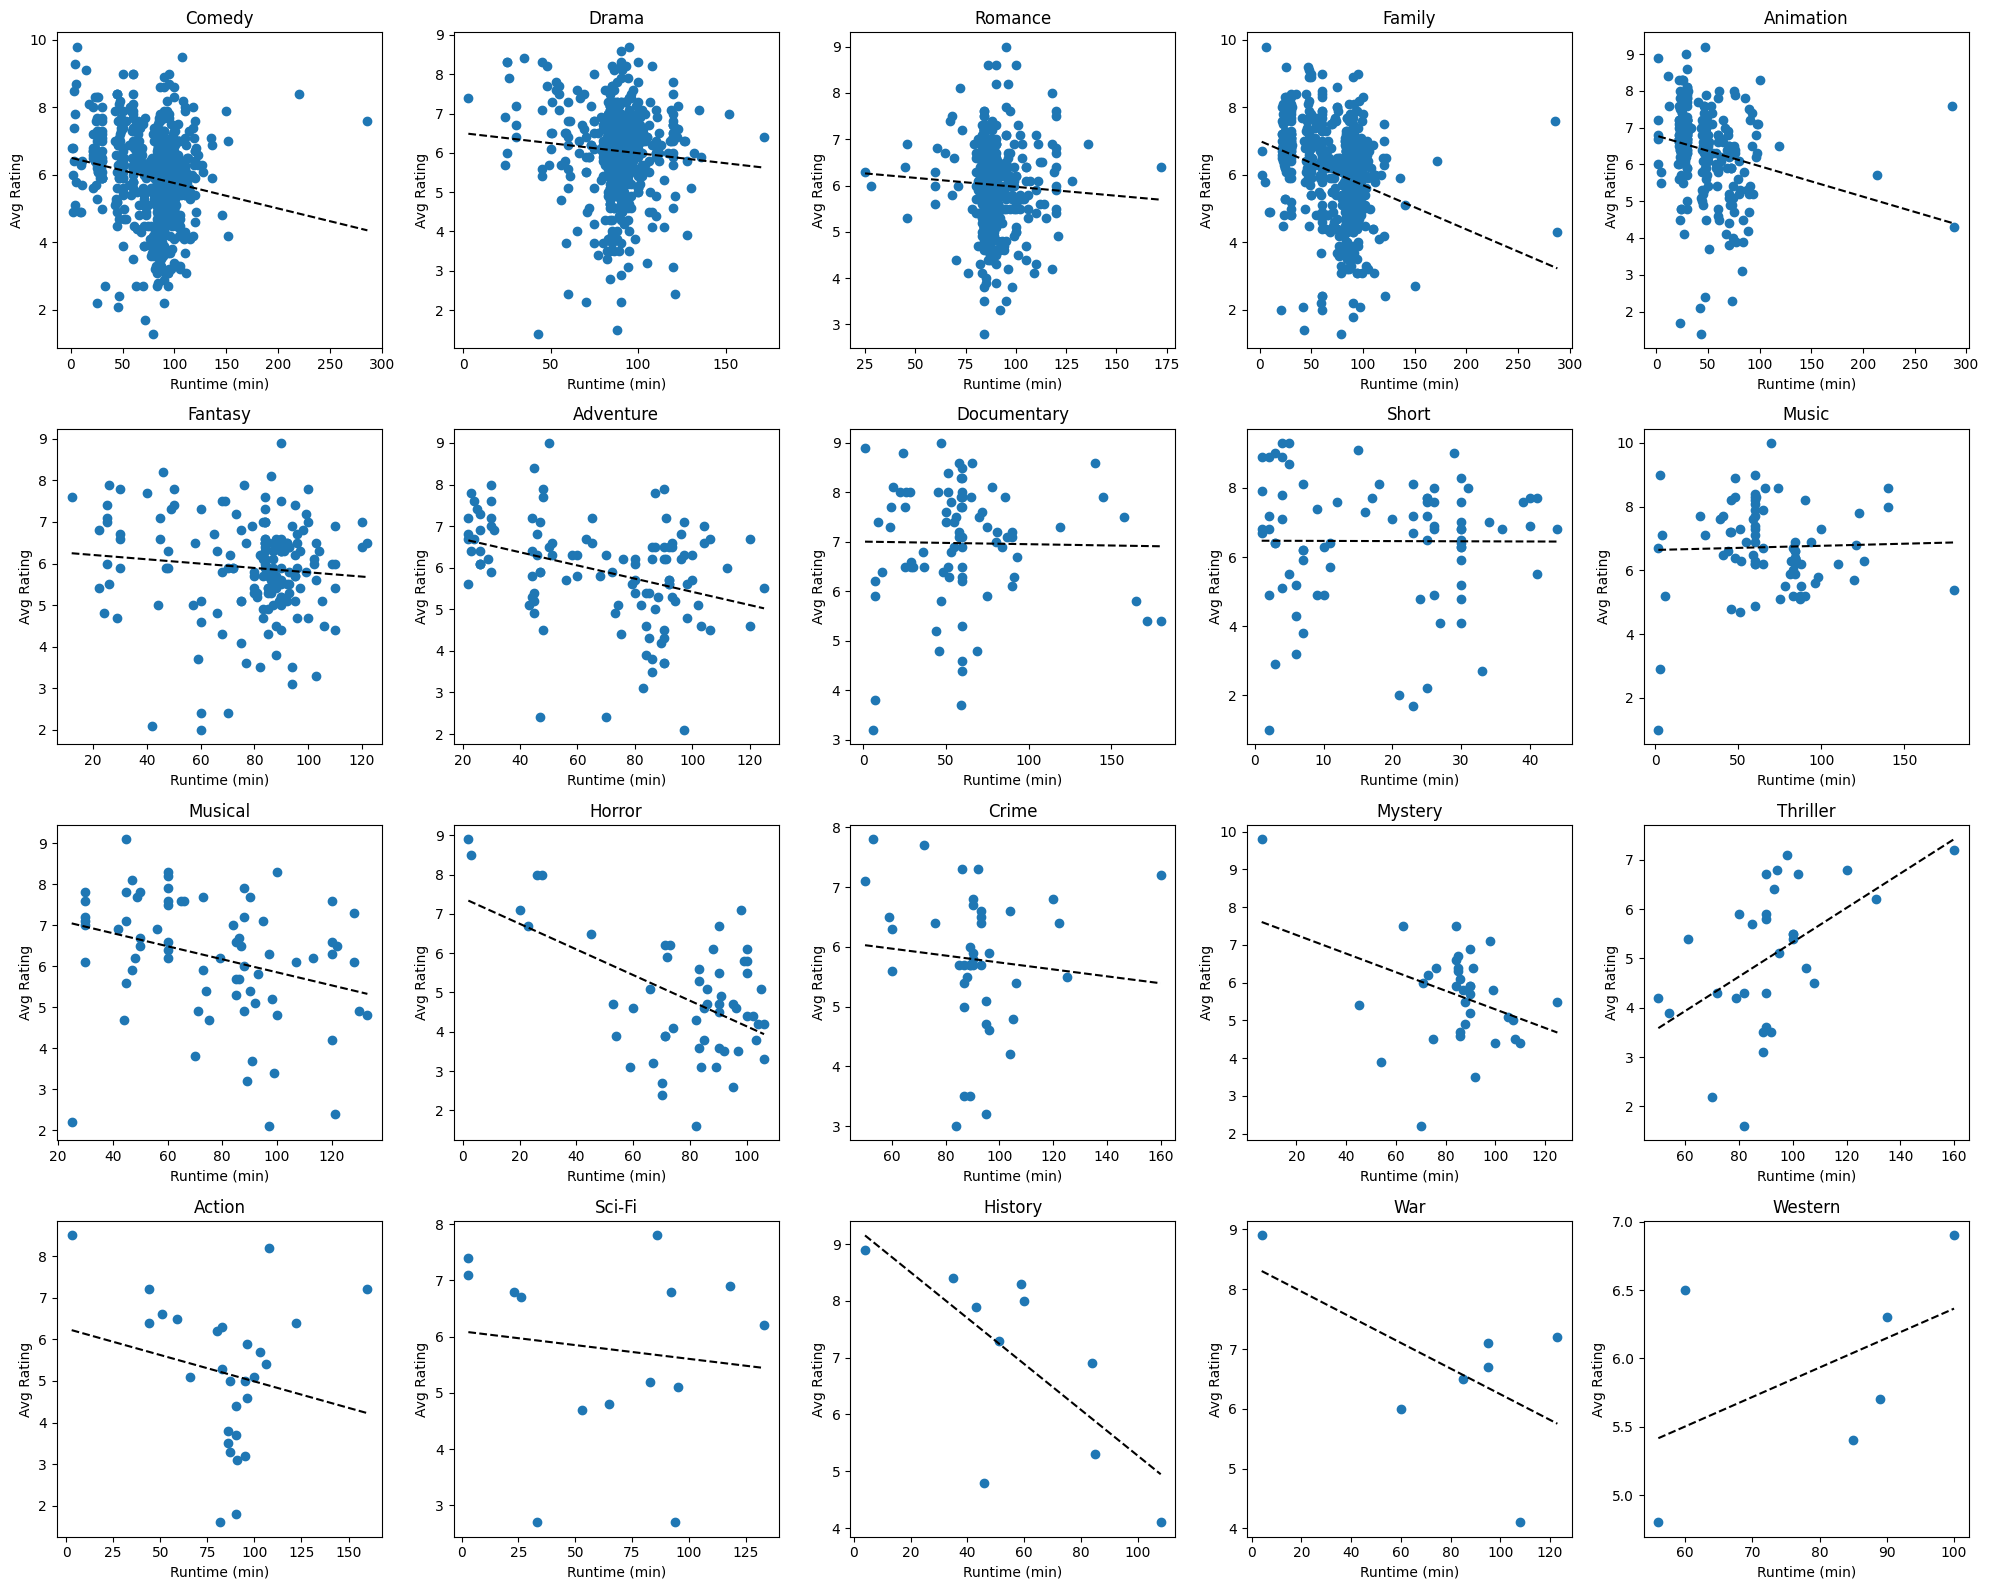

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1) Get top 20 genres
genre_counts = holiday_movies_exploded['genres'].value_counts()
top_20_genres = genre_counts.head(20).index

# 2) Create subplots grid: 4 rows x 5 columns = 20 subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
axes = axes.ravel()  # Flatten the 2D axes array to a 1D array for easy indexing

for i, genre in enumerate(top_20_genres):
    # 3) Subset DataFrame for this genre
    subset = holiday_movies_exploded[
        holiday_movies_exploded['genres'] == genre
    ].dropna(subset=['runtime_minutes', 'average_rating'])
    
    # If there's not enough data, skip plotting
    if subset.shape[0] < 2:
        axes[i].set_title(f"{genre} (Not enough data)")
        axes[i].set_xlabel('Runtime (min)')
        axes[i].set_ylabel('Avg Rating')
        continue
    
    # Scatter plot
    x = subset['runtime_minutes']
    y = subset['average_rating']
    axes[i].scatter(x, y)
    
    # 4) Compute regression and plot line
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    
    # Make a sequence of x-values for the line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    
    axes[i].plot(x_line, y_line, linestyle='--', color='black')
    
    # Subplot labeling
    axes[i].set_title(genre)
    axes[i].set_xlabel('Runtime (min)')
    axes[i].set_ylabel('Avg Rating')

plt.tight_layout()  # Avoid overlapping labels
plt.show()


# Question 2

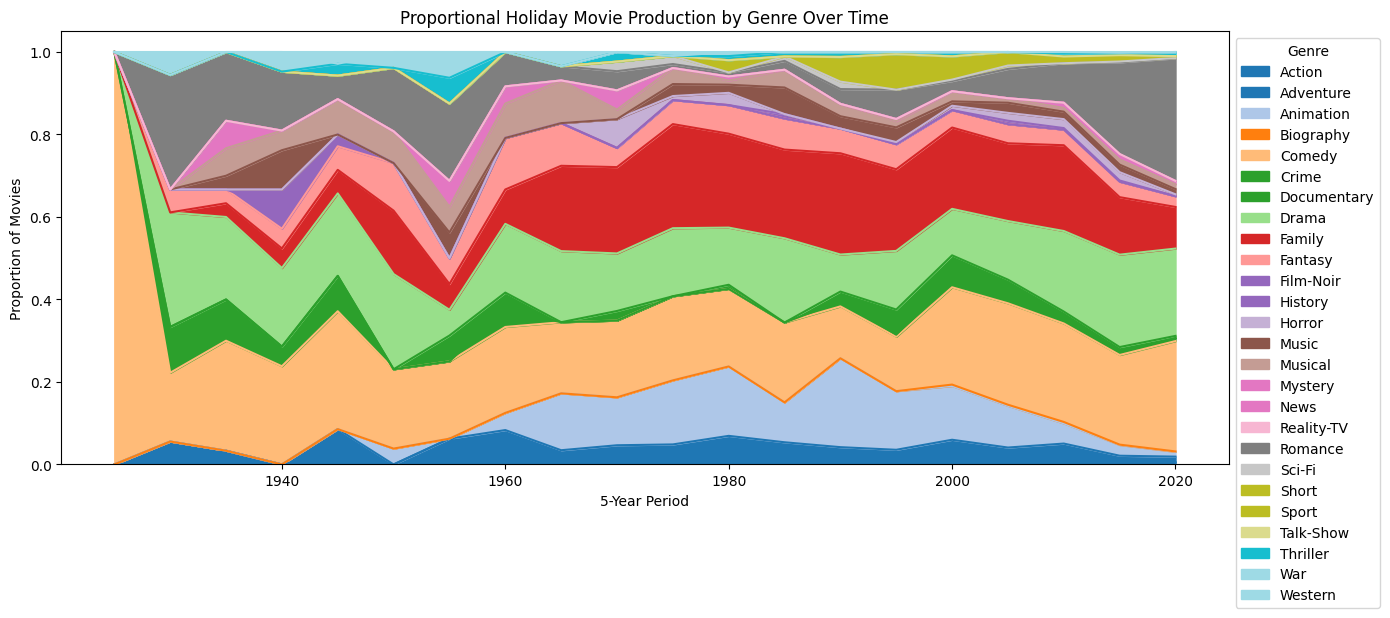

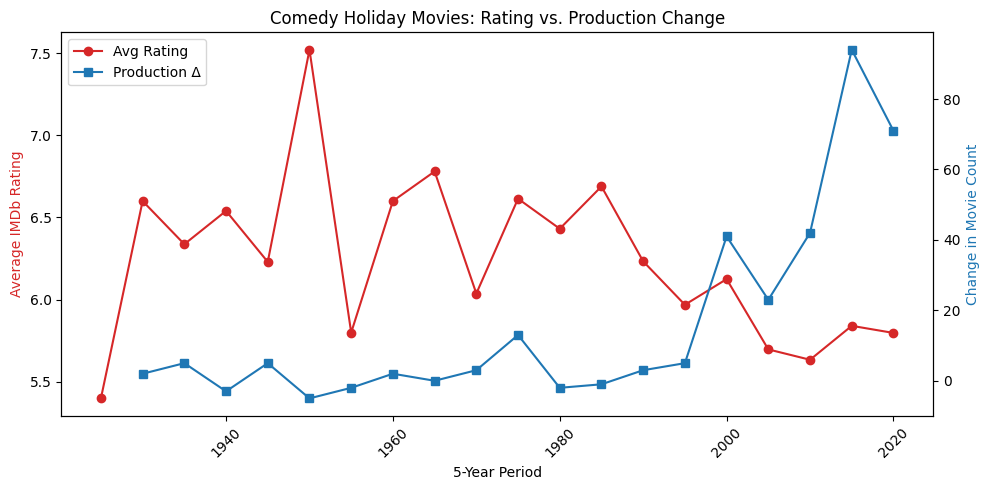

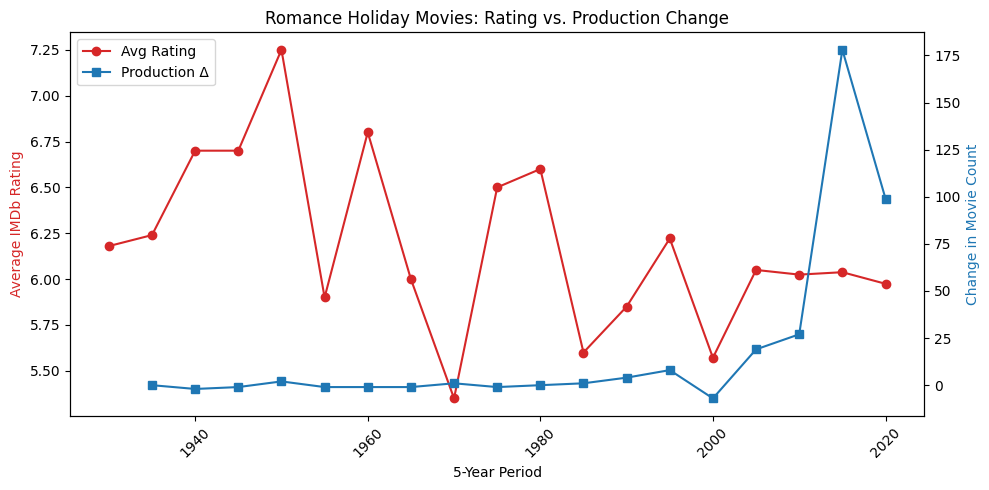

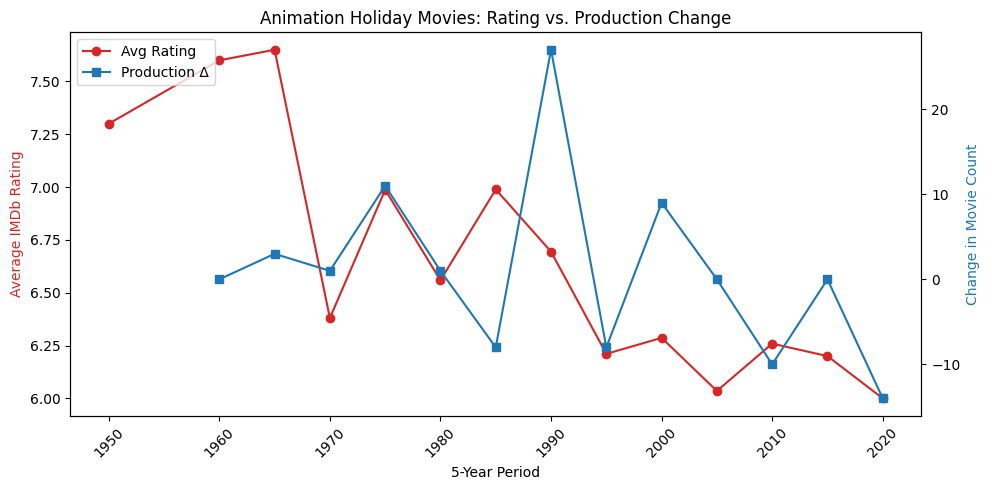

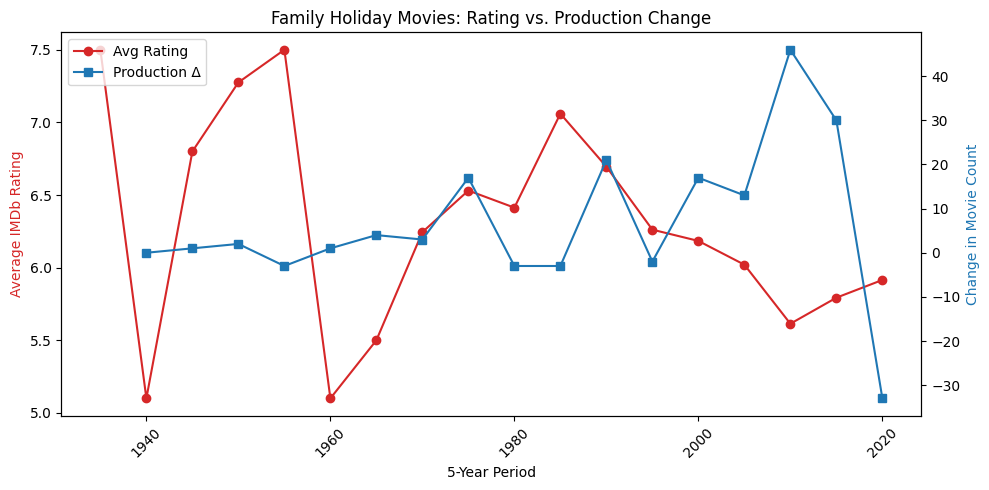

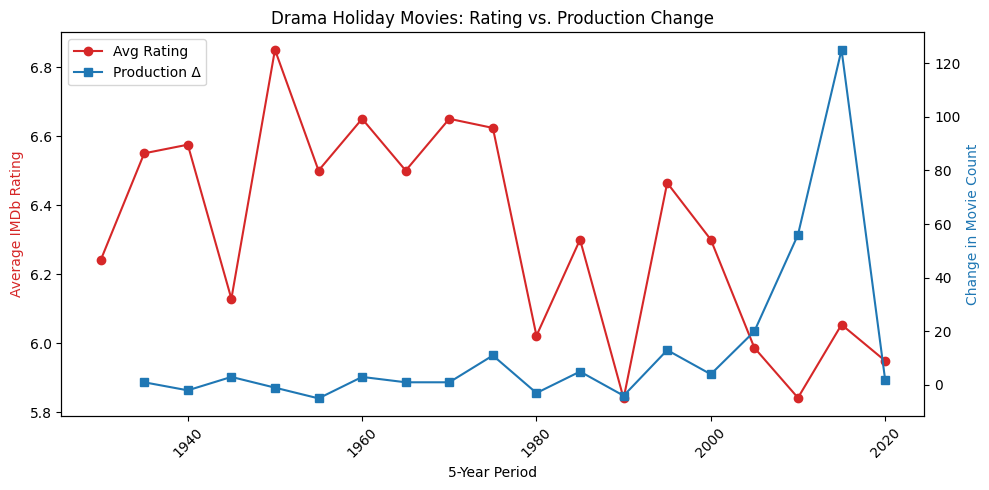

In [13]:
# Load the dataset
df = pd.read_csv("holiday_movies.csv")

# Clean missing data and explode genres
df = df.dropna(subset=['average_rating', 'runtime_minutes', 'genres'])
df['year_period'] = (df['year'] // 5) * 5
df['genres'] = df['genres'].str.split(',')
df_exploded = df.explode('genres')

# Aggregate total movie count by period and genre
genre_counts = df_exploded.groupby(['year_period', 'genres']).agg(
    count=('tconst', 'count')
).reset_index()

# Pivot to wide format for stacked area chart
pivot_counts = genre_counts.pivot(index='year_period', columns='genres', values='count').fillna(0)

# Normalize each row to get proportions (100% stacked)
pivot_props = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

# Plot the 100% stacked area chart
pivot_props.plot(kind='area', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Proportional Holiday Movie Production by Genre Over Time")
plt.xlabel("5-Year Period")
plt.ylabel("Proportion of Movies")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Genre')
plt.tight_layout()
plt.show()

# Focus on 5 key genres
focus_genres = ['Comedy', 'Romance', 'Animation', 'Family', 'Drama']

# Aggregate stats by 5-year period and genre
agg = df_exploded[df_exploded['genres'].isin(focus_genres)].groupby(
    ['year_period', 'genres']
).agg(
    avg_rating=('average_rating', 'mean'),
    movie_count=('tconst', 'count')
).reset_index()

# Sort and calculate rate of change in movie count
agg = agg.sort_values(['genres', 'year_period'])
agg['production_change'] = agg.groupby('genres')['movie_count'].diff()

# Plot all 5 genres in one go
for genre in focus_genres:
    data = agg[agg['genres'] == genre]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(data['year_period'], data['avg_rating'], color='tab:red', marker='o', label='Avg Rating')
    ax2.plot(data['year_period'], data['production_change'], color='tab:blue', marker='s', label='Production Δ')

    ax1.set_xlabel('5-Year Period')
    ax1.set_ylabel('Average IMDb Rating', color='tab:red')
    ax2.set_ylabel('Change in Movie Count', color='tab:blue')
    plt.title(f'{genre} Holiday Movies: Rating vs. Production Change')
    ax1.tick_params(axis='x', rotation=45)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()
